In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Optional: Rename folders if needed (to remove spaces)
folder_map = {
    "fridge dataset": "fridge_dataset",
    "table dataset": "table_dataset",
    "tv dataset": "tv_dataset"
}
for old_name, new_name in folder_map.items():
    if os.path.exists(f'furniture-image-dataset/{old_name}'):
        os.rename(f'furniture-image-dataset/{old_name}', f'furniture-image-dataset/{new_name}')

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

2025-04-22 10:56:36.989662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745319397.242677      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745319397.318972      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load dataset
data_path = '/kaggle/input/furniture-image-dataset'
batch_size = 32
img_size = (224, 224)

# Load datasets first (without prefetch)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# ✅ Get class names BEFORE prefetching
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Now add prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=AUTOTUNE)


Found 15000 files belonging to 5 classes.
Using 12000 files for training.
Found 15000 files belonging to 5 classes.
Using 3000 files for validation.


In [6]:
class_names

['almirah_dataset',
 'chair_dataset',
 'fridge dataset',
 'table dataset',
 'tv dataset']

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Create model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze initial layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile and train head
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=5)

# Fine-tune full model
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/5


I0000 00:00:1745317160.515199      96 service.cc:148] XLA service 0x79a87c003110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745317160.517393      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745317162.110174      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/375 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3125 - loss: 1.5193   

I0000 00:00:1745317165.984999      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.9570 - loss: 0.1126 - val_accuracy: 1.0000 - val_loss: 4.7726e-04
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 1.0000 - loss: 3.5008e-04 - val_accuracy: 1.0000 - val_loss: 1.9432e-04
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 1.0000 - loss: 1.4987e-04 - val_accuracy: 1.0000 - val_loss: 9.9600e-05
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 1.0000 - loss: 7.8088e-05 - val_accuracy: 1.0000 - val_loss: 5.7629e-05
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 1.0000 - loss: 4.6249e-05 - val_accuracy: 1.0000 - val_loss: 3.6823e-05
Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 139s 182ms/step - accuracy: 0.9588 - loss: 0.1682 - val_accuracy: 1.0000 - val_loss: 5.3291e-05
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 164ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.6959e-05
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


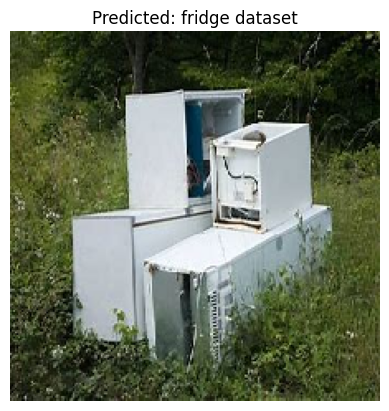

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your image
img_path = '/kaggle/input/one-image/Refri.jpg'

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Shape becomes (1, 224, 224, 3)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Normalize

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}")
plt.show()

In [10]:
# Save the entire model as an HDF5 file
model.save("furniture_resnet_model.h5")